In [1]:
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
import numpy as np

In [2]:
data = pd.read_csv('C:\\Users\\corey\\Desktop\\git\\portfolio\\data_portfolio\\realestate_ml\\data\\houston_houses_cleaned.csv')
data = data.drop('Unnamed: 0', axis=1)
data.head()

,bedrooms,Sqft.,lot Sqft.,full baths,half baths,stories,year built,Private Pool,zip,price
0,3.0,1758.0,7150.0,2.0,0,1.0,1978.0,False,77084,221000.0
1,4.0,2958.0,9400.0,3.0,1,2.0,1980.0,False,77070,359500.0
2,3.0,1120.0,6000.0,2.0,0,1.0,1936.0,False,77008,825000.0
3,3.0,1714.0,5500.0,2.0,0,1.0,1986.0,False,77095,289995.0
4,2.0,1180.0,6960.0,1.0,0,1.0,1955.0,False,77033,128000.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31331 entries, 0 to 31330
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bedrooms      31331 non-null  float64
 1   Sqft.         31331 non-null  float64
 2   lot Sqft.     31331 non-null  float64
 3   full baths    31331 non-null  float64
 4   half baths    31331 non-null  int64  
 5   stories       31331 non-null  float64
 6   year built    31331 non-null  float64
 7   Private Pool  31331 non-null  bool   
 8   zip           31331 non-null  int64  
 9   price         31331 non-null  float64
dtypes: bool(1), float64(7), int64(2)
memory usage: 2.2 MB


In [4]:
data[['bedrooms', 'full baths', 'half baths','zip']] = data[['bedrooms', 'full baths', 'half baths','zip']].astype(str)

In [5]:
def reduceZip(df, how='median', bins=5):
    """
    Accepts: dataframe, number of bins and which stat to groupby
    Returns: dataframe with new column categorizing zipcodes by price
    """
    zipGrouped = df[['zip', 'price']].groupby(['zip']).median() if how == 'median' else df.groupby(['zip']).mean()
    zipGrouped['zipTier'] = pd.cut(zipGrouped['price'], bins=bins, labels=False)
    zipGrouped = zipGrouped.drop(['price'], axis=1)
    return df.merge(zipGrouped, how='left', on='zip')

data = reduceZip(data)

In [6]:
data['age'] = data.apply(lambda x: 2022 - x['year built'] + 1 if x['year built'] else 0, axis=1)
data = data.drop(['year built'], axis=1)
data.describe()

,Sqft.,lot Sqft.,stories,price,zipTier,age
count,31331.000000,3.133100e+04,31331.000000,3.133100e+04,31331.000000,31331.000000
mean,2382.059270,1.127894e+04,1.524319,4.950054e+05,0.601098,21.063835
std,1122.423208,4.512432e+04,0.588196,5.750877e+05,0.658818,26.231951
min,0.000000,0.000000e+00,1.000000,1.000000e+00,0.000000,0.000000
25%,1685.000000,1.667500e+03,1.000000,2.875000e+05,0.000000,1.000000
50%,2182.000000,6.395000e+03,1.000000,3.750000e+05,1.000000,12.000000
75%,2826.000000,8.800000e+03,2.000000,5.290000e+05,1.000000,39.000000
max,30717.000000,1.441410e+06,5.000000,2.650000e+07,4.000000,1823.000000


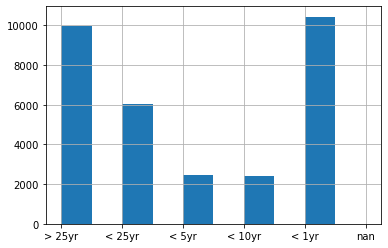

In [7]:
# The majority of homes are brand new or older than 25 years
data['age_cat'] = pd.cut(data['age'], 
                         bins=[0, 1, 5, 10, 25, np.inf], 
                         labels=['< 1yr', '< 5yr', '< 10yr', '< 25yr', '> 25yr'])
data = data.drop('age', axis=1)
data[['age_cat']] = data[['age_cat']].astype(str)
data['age_cat'].hist()
plt.show()

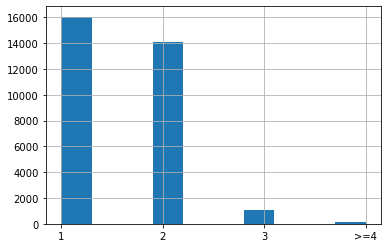

In [8]:
data['stories_cat'] = pd.cut(data['stories'], 
                         bins=[0, 1, 2, 3, np.inf], 
                         labels=['1', '2', '3', '>=4'])
data = data.drop('stories', axis=1)
data[['stories_cat']] = data[['stories_cat']].astype(str)
data['stories_cat'].hist()
plt.show()

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31331 entries, 0 to 31330
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bedrooms      31331 non-null  object 
 1   Sqft.         31331 non-null  float64
 2   lot Sqft.     31331 non-null  float64
 3   full baths    31331 non-null  object 
 4   half baths    31331 non-null  object 
 5   Private Pool  31331 non-null  bool   
 6   zip           31331 non-null  object 
 7   price         31331 non-null  float64
 8   zipTier       31331 non-null  int64  
 9   age_cat       31331 non-null  object 
 10  stories_cat   31331 non-null  object 
dtypes: bool(1), float64(3), int64(1), object(6)
memory usage: 2.7+ MB


In [14]:
X = data.drop(['price', 'zip'], axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X.columns)

Index(['bedrooms', 'Sqft.', 'lot Sqft.', 'full baths', 'half baths',
       'Private Pool', 'zipTier', 'age_cat', 'stories_cat'],
      dtype='object')


In [15]:
cat_col = ['bedrooms', 'full baths', 'half baths', 'stories_cat', 'zipTier', 'Private Pool', 'age_cat']
num_col = ['Sqft.', 'lot Sqft.', 'full baths']

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_col),
        ("cat", OneHotEncoder(), cat_col),
    ])

X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)

In [16]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=100,
                                max_depth=None,
                                bootstrap=True,
                                n_jobs=1, 
                                random_state=42).fit(X_train_prepared, y_train)
forest.score(X_test_prepared, y_test)                                    

0.4937796690984185

In [17]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':(10, 25, 100),
              'max_depth':(None, 2, 5),
              'bootstrap':(True, False),
              'warm_start':(True, False)}
forest_reg = RandomForestRegressor(n_jobs=-1)
gs_forest = GridSearchCV(forest_reg, parameters)

gs_forest.fit(X_train_prepared, y_train)
gs_forest.get_params()

{'cv': None,
 'error_score': nan,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'squared_error',
 'estimator__max_depth': None,
 'estimator__max_features': 1.0,
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': -1,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestRegressor(n_jobs=-1),
 'n_jobs': None,
 'param_grid': {'n_estimators': (10, 25, 100),
  'max_depth': (None, 2, 5),
  'bootstrap': (True, False),
  'warm_start': (True, False)},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

In [18]:
print(f'coef of determination = {gs_forest.score(X_test_prepared, y_test)}')
print(f'MAE = {mean_squared_error(y_test, gs_forest.predict(X_test_prepared))}')

coef of determination = 0.4979828249032813
MAE = 160396252597.5233
